In [1]:
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# PyTorch Geometric
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx

import scipy.sparse as sp

# GraphCL modules
import sys
sys.path.append('./GraphCL')
from aug import *
from models.dgi import DGI
from models.logreg import LogReg
from utils.process import normalize_adj, preprocess_adj, sparse_mx_to_torch_sparse_tensor

# Standard libraries
import numpy as np
import networkx as nx
import pickle
import os
from glob import glob
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, silhouette_score, davies_bouldin_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm

print("Imports complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

c:\Portable\ProgramsPortable\Anaconda\envs\graphml\Lib\site-packages\torch_geometric\typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(
c:\Portable\ProgramsPortable\Anaconda\envs\graphml\Lib\site-packages\torch_geometric\typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


Imports complete!
PyTorch version: 2.7.1+cu118
CUDA available: True


### Load all graphs and split them into train/test/val

In [2]:
# Load all graph files
graph_files = sorted(glob('./graphs/*.pkl'))
print(f"Found {len(graph_files)} graphs")

# Load graphs
graphs = []
for file in graph_files:
    with open(file, 'rb') as f:
        G = pickle.load(f)
        graphs.append(G)
    
print(f"Loaded {len(graphs)} graphs")

# Print stats for first graph
G_sample = graphs[0]
print(f"\nSample graph stats:")
print(f"  Nodes: {G_sample.number_of_nodes()}")
print(f"  Edges: {G_sample.number_of_edges()}")
print(f"  Type: {type(G_sample)}")

# Split into train (70%), val (15%), test (15%)
train_graphs, temp_graphs = train_test_split(graphs, test_size=0.3, random_state=42)
val_graphs, test_graphs = train_test_split(temp_graphs, test_size=0.5, random_state=42)

print(f"\nSplit:")
print(f"  Train: {len(train_graphs)} graphs")
print(f"  Val: {len(val_graphs)} graphs")
print(f"  Test: {len(test_graphs)} graphs")

Found 112 graphs
Loaded 112 graphs

Sample graph stats:
  Nodes: 39
  Edges: 293
  Type: <class 'networkx.classes.digraph.DiGraph'>

Split:
  Train: 78 graphs
  Val: 17 graphs
  Test: 17 graphs


## Inspect sample graph

In [3]:
# Inspect a sample graph
G_sample = train_graphs[0]

print("Node attributes:")
sample_node = list(G_sample.nodes())[0]
print(f"  Node ID: {sample_node}")
print(f"  Attributes: {G_sample.nodes[sample_node]}")

print(f"\nEdge attributes:")
sample_edge = list(G_sample.edges())[0]
print(f"  Edge: {sample_edge}")
print(f"  Attributes: {G_sample.edges[sample_edge]}")

# Check if nodes have features
has_features = len(G_sample.nodes[sample_node]) > 0
print(f"\nNodes have features: {has_features}")

# Get all unique nodes across all graphs (for consistent indexing)
all_nodes = set()
for G in graphs:
    all_nodes.update(G.nodes())
all_nodes = sorted(list(all_nodes))
print(f"\nTotal unique nodes (zones): {len(all_nodes)}")
print(f"Node IDs: {all_nodes}")

Node attributes:
  Node ID: 19
  Attributes: {'event_count': 18, 'most_common_event': 'PASS', 'unique_players': 4, 'zone_name': 'RIGHT_WING_DEF_THIRD', 'role_distribution': array([0.  , 0.5 , 0.25, 0.25])}

Edge attributes:
  Edge: (19, 29)
  Attributes: {'weight': 4, 'transition_frequency': 0.36363636363636365, 'most_common_event': 'PASS', 'start_zone_name': 'RIGHT_WING_DEF_THIRD', 'end_zone_name': 'RIGHT_WING_MID_THIRD_ATT'}

Nodes have features: True

Total unique nodes (zones): 41
Node IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


In [4]:

all_event_types = set()
for G in graphs:
    for node, attrs in G.nodes(data=True):
        event = attrs['most_common_event']
        if event is not None:  # Skip None values
            all_event_types.add(event)
all_event_types = sorted(list(all_event_types))
event_to_idx = {event: idx for idx, event in enumerate(all_event_types)}
event_to_idx[None] = len(all_event_types)  # Give None its own index

print(f"Event types found: {all_event_types}")
print(f"Event encoding (including None): {event_to_idx}")


Event types found: ['DUEL', 'GOALKEEPER', 'PASS', 'SHOT']
Event encoding (including None): {'DUEL': 0, 'GOALKEEPER': 1, 'PASS': 2, 'SHOT': 3, None: 4}


### Convert Graphs to PyTorch Geometric Format

In [5]:
def convert_graph_to_pyg(G):
    """Convert NetworkX graph to PyG format"""
    nodes = sorted(list(G.nodes()))
    num_nodes = len(nodes)
    
    # Features: event_count(1) + event_type_encoded(len+1 for None) + unique_players(1) + role_distribution(4)
    num_event_types = len(event_to_idx)
    feature_dim = 1 + num_event_types + 1 + 4
    features = np.zeros((num_nodes, feature_dim))
    
    node_map = {node: i for i, node in enumerate(nodes)}
    
    for i, node in enumerate(nodes):
        attrs = G.nodes[node]
        features[i, 0] = attrs['event_count']
        # One-hot encode most_common_event
        event_idx = event_to_idx[attrs['most_common_event']]
        features[i, 1 + event_idx] = 1.0
        features[i, 1 + num_event_types] = attrs['unique_players']
        features[i, 2 + num_event_types:] = attrs['role_distribution']
    
    # Create edge index
    edge_index = []
    for src, dst in G.edges():
        edge_index.append([node_map[src], node_map[dst]])
    edge_index = torch.LongTensor(edge_index).t().contiguous()
    
    data = Data(x=torch.FloatTensor(features), edge_index=edge_index, num_nodes=num_nodes)
    return data

In [6]:
data_sample = convert_graph_to_pyg(train_graphs[0])
print(f"Conversion:")
print(f"  Nodes: {data_sample.num_nodes}")
print(f"  Edges: {data_sample.edge_index.shape[1]}")
print(f"  Feature shape: {data_sample.x.shape}")
print(f"  First node features:\n{data_sample.x[0]}")


Conversion:
  Nodes: 40
  Edges: 256
  Feature shape: torch.Size([40, 11])
  First node features:
tensor([2.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 2.0000, 0.5000, 0.0000,
        0.5000, 0.0000])


In [7]:
# Convert all graphs with fixed function
train_data = [convert_graph_to_pyg(G) for G in train_graphs]
val_data = [convert_graph_to_pyg(G) for G in val_graphs]
test_data = [convert_graph_to_pyg(G) for G in test_graphs]

print(f"\nConverted all graphs!")
print(f"  Train: {len(train_data)} graphs")
print(f"  Val: {len(val_data)} graphs")
print(f"  Test: {len(test_data)} graphs")


Converted all graphs!
  Train: 78 graphs
  Val: 17 graphs
  Test: 17 graphs


## Configure encoder DGI

In [8]:
def preprocess_graph_for_dgi_undirected(data):
    """
    Convert PyG Data to undirected format for GraphCL
    """
    # Node features [1, num_nodes, features]
    features = data.x.unsqueeze(0).cpu()
    
    # Build SYMMETRIC sparse adjacency matrix
    edge_index = data.edge_index.cpu().numpy()
    num_nodes = data.num_nodes
    
    # Create sparse adjacency (COO format)
    adj = sp.coo_matrix(
        (np.ones(edge_index.shape[1]), (edge_index[0], edge_index[1])),
        shape=(num_nodes, num_nodes)
    )
    
    # Make symmetric (undirected)
    adj = adj + adj.T
    adj = (adj > 0).astype(float)  # Binary adjacency
    adj = sp.coo_matrix(adj)
    
    return features, adj

In [9]:
# Test GraphCL augmentation functions
data_sample = train_data[0]
features, adj_sparse = preprocess_graph_for_dgi_undirected(data_sample)

# Convert adj to sparse for GraphCL functions
# adj_sparse = sp.coo_matrix(adj[0].numpy())
# adj_sparse = adj_sparse + adj_sparse.T
print("Original graph:")
print(f"  Features shape: {features.shape}")
print(f"  Nodes: {features.shape[1]}")
print(f"  Edges: {adj_sparse.nnz // 2}")  # Undirected

# Test different augmentation types
aug_type = 'mask'
drop_percent = 0.2

if aug_type == 'edge':
    aug_features1 = features
    aug_adj1 = aug_random_edge(adj_sparse, drop_percent=drop_percent)
    print(f"\nEdge augmentation (drop {drop_percent*100}%):")
    print(f"  Edges after: {aug_adj1.nnz // 2}")
    
elif aug_type == 'mask':
    aug_features1 = aug_random_mask(features, drop_percent=drop_percent)
    aug_adj1 = adj_sparse
    print(f"\nMask augmentation (mask {drop_percent*100}%):")
    print(f"  Masked features: {(aug_features1[0] == 0).all(1).sum().item()}")
    
elif aug_type == 'node':
    aug_features1, aug_adj1 = aug_drop_node(features, adj_sparse, drop_percent=drop_percent)
    print(f"\nNode drop augmentation ({drop_percent*100}%):")
    print(f"  Nodes after: {aug_features1.shape[1]}")
    print(f"  Edges after: {aug_adj1.nnz // 2}")
    
elif aug_type == 'subgraph':
    aug_features1, aug_adj1 = aug_subgraph(features, adj_sparse, drop_percent=drop_percent)
    print(f"\nSubgraph augmentation ({(1-drop_percent)*100}% nodes):")
    print(f"  Nodes after: {aug_features1.shape[1]}")
    print(f"  Edges after: {aug_adj1.nnz // 2}")

Original graph:
  Features shape: torch.Size([1, 40, 11])
  Nodes: 40
  Edges: 203

Mask augmentation (mask 20.0%):
  Masked features: 8


### Set up hyperparameters

In [10]:
# Hyperparameters
input_dim = train_data[0].x.shape[1]
hidden_dim = 32
learning_rate = 0.001
num_epochs = 100
temperature = 0.2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Configuration:")
print(f"  Input dim: {input_dim}")
print(f"  Hidden dim: {hidden_dim}")
print(f"  Device: {device}")
print(f"  Num graphs: Train={len(train_data)}, Val={len(val_data)}, Test={len(test_data)}")

# Initialize encoder
encoder = DGI(input_dim, hidden_dim, 'prelu').to(device)
print(f"\nDGI encoder initialized!")
print(f"  Architecture: GCN -> {hidden_dim}D embeddings")

Configuration:
  Input dim: 11
  Hidden dim: 32
  Device: cuda
  Num graphs: Train=78, Val=17, Test=17


c:\Portable\ProgramsPortable\Anaconda\envs\graphml\Lib\site-packages\torch\cuda\__init__.py:287: UserWarning: 
NVIDIA GeForce RTX 5080 Laptop GPU with CUDA capability sm_120 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 sm_80 sm_86 sm_90 compute_37.
If you want to use the NVIDIA GeForce RTX 5080 Laptop GPU GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(



DGI encoder initialized!
  Architecture: GCN -> 32D embeddings


In [11]:
# Hyperparameters
aug_type = 'mask'  # Options: 'edge', 'mask', 'node', 'subgraph'
drop_percent = 0.3
nb_epochs = 1000
patience = 50
lr = 0.001
l2_coef = 0.0
sparse = True

# Loss function and optimizer
b_xent = nn.BCEWithLogitsLoss()
optimiser = torch.optim.Adam(encoder.parameters(), lr=lr, weight_decay=l2_coef)

# Move encoder to device
encoder = encoder.to(device)

print(f"Device: {device}")
print(f"\nReady to train on {len(train_data)} graphs!")

Device: cuda

Ready to train on 78 graphs!


#### Train GraphCL

In [12]:
# Training hyperparameters
accumulation_steps = 8  # Accumulate over 8 graphs before updating
batch_size = 1  # Still process 1 graph at a time

cnt_wait = 0
best = 1e9
best_t = 0
save_name = 'graphcl_best_32d.pkl'

print("Starting training with gradient accumulation...")
print("="*60)

for epoch in range(nb_epochs):
    encoder.train()
    epoch_loss = 0
    
    # Loop through all training graphs
    for i, data in enumerate(train_data):
        # Preprocess graph
        features, adj_sparse = preprocess_graph_for_dgi_undirected(data)
        nb_nodes = features.shape[1]
        
        # Create augmentations
        if aug_type == 'mask':
            aug_features1 = aug_random_mask(features, drop_percent=drop_percent)
            aug_features2 = aug_random_mask(features, drop_percent=drop_percent)
            aug_adj1 = adj_sparse
            aug_adj2 = adj_sparse
        elif aug_type == 'edge':
            aug_features1 = features
            aug_features2 = features
            aug_adj1 = aug_random_edge(adj_sparse, drop_percent=drop_percent)
            aug_adj2 = aug_random_edge(adj_sparse, drop_percent=drop_percent)
        elif aug_type == 'node':
            aug_features1, aug_adj1 = aug_drop_node(features, adj_sparse, drop_percent=drop_percent)
            aug_features2, aug_adj2 = aug_drop_node(features, adj_sparse, drop_percent=drop_percent)
        elif aug_type == 'subgraph':
            aug_features1, aug_adj1 = aug_subgraph(features, adj_sparse, drop_percent=drop_percent)
            aug_features2, aug_adj2 = aug_subgraph(features, adj_sparse, drop_percent=drop_percent)

        # Normalize adjacencies and add self-loops
        adj_norm = normalize_adj(adj_sparse + sp.eye(adj_sparse.shape[0]))
        aug_adj1_norm = normalize_adj(aug_adj1 + sp.eye(aug_adj1.shape[0]))
        aug_adj2_norm = normalize_adj(aug_adj2 + sp.eye(aug_adj2.shape[0]))
        
        # Convert to sparse tensors
        sp_adj = sparse_mx_to_torch_sparse_tensor(adj_norm).cuda()
        sp_aug_adj1 = sparse_mx_to_torch_sparse_tensor(aug_adj1_norm).cuda()
        sp_aug_adj2 = sparse_mx_to_torch_sparse_tensor(aug_adj2_norm).cuda()
        
        # Move features to GPU
        features = features.cuda()
        aug_features1 = aug_features1.cuda()
        aug_features2 = aug_features2.cuda()
        
        # Create negative sample (shuffled features)
        idx = np.random.permutation(nb_nodes)
        shuf_fts = features[:, idx, :].cuda()
        
        # Create labels (batch_size=1 for single graph!)
        lbl_1 = torch.ones(batch_size, nb_nodes)
        lbl_2 = torch.zeros(batch_size, nb_nodes)
        lbl = torch.cat((lbl_1, lbl_2), 1).cuda()
        
        # Forward pass through DGI
        logits = encoder(features, shuf_fts, aug_features1, aug_features2,
                        sp_adj, sp_aug_adj1, sp_aug_adj2,
                        sparse, None, None, None, aug_type=aug_type)
        
        # Compute loss (scaled for accumulation)
        loss = b_xent(logits, lbl) / accumulation_steps
        epoch_loss += loss.item() * accumulation_steps  # Unscale for logging
        
        # Backward pass (accumulate gradients)
        loss.backward()
        
        # Update weights every accumulation_steps
        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_data):
            optimiser.step()
            optimiser.zero_grad()
    
    # Average loss over all graphs
    avg_loss = epoch_loss / len(train_data)
    
    # Print progress every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch:4d} | Loss: {avg_loss:.4f} | Best: {best:.4f} @ epoch {best_t}')
    
    # Early stopping check
    if avg_loss < best:
        best = avg_loss
        best_t = epoch
        cnt_wait = 0
        torch.save(encoder.state_dict(), save_name)
    else:
        cnt_wait += 1
    
    if cnt_wait == patience:
        print('='*60)
        print(f'Early stopping at epoch {epoch}!')
        break

print('='*60)
print(f'Training finished!')
print(f'Best loss: {best:.4f} at epoch {best_t}')
print(f'Model saved to: {save_name}')

Starting training with gradient accumulation...


c:\Portable\Projects\Graph ML\Football-Tactical-Clustering\./GraphCL\utils\process.py:211: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:656.)
  return torch.sparse.FloatTensor(indices, values, shape)


Epoch    0 | Loss: 1.1942 | Best: 1000000000.0000 @ epoch 0
Epoch   10 | Loss: 0.6898 | Best: 0.6913 @ epoch 9
Epoch   20 | Loss: 0.6784 | Best: 0.6805 @ epoch 19
Epoch   30 | Loss: 0.6687 | Best: 0.6690 @ epoch 29
Epoch   40 | Loss: 0.6620 | Best: 0.6613 @ epoch 38
Epoch   50 | Loss: 0.6534 | Best: 0.6456 @ epoch 47
Epoch   60 | Loss: 0.6471 | Best: 0.6456 @ epoch 47
Epoch   70 | Loss: 0.6505 | Best: 0.6420 @ epoch 67
Epoch   80 | Loss: 0.6506 | Best: 0.6420 @ epoch 67
Epoch   90 | Loss: 0.6450 | Best: 0.6363 @ epoch 88
Epoch  100 | Loss: 0.6366 | Best: 0.6349 @ epoch 99
Epoch  110 | Loss: 0.6425 | Best: 0.6349 @ epoch 99
Epoch  120 | Loss: 0.6439 | Best: 0.6314 @ epoch 111
Epoch  130 | Loss: 0.6399 | Best: 0.6308 @ epoch 126
Epoch  140 | Loss: 0.6279 | Best: 0.6303 @ epoch 135
Epoch  150 | Loss: 0.6369 | Best: 0.6279 @ epoch 140
Epoch  160 | Loss: 0.6353 | Best: 0.6279 @ epoch 140
Epoch  170 | Loss: 0.6197 | Best: 0.6257 @ epoch 169
Epoch  180 | Loss: 0.6247 | Best: 0.6197 @ epoch 17

### Load trained graph

In [13]:
input_dim = train_data[0].x.shape[1]
hidden_dim = 32
encoder = DGI(input_dim, hidden_dim, 'prelu').to(device)
save_name = 'graphcl_best_32d.pkl'
# Load best model
print("Loading best model...")
encoder.load_state_dict(torch.load(save_name))
encoder.eval()

print(f"Model loaded")
print("="*60)

# Extract embeddings from all graphs
def extract_embeddings(graphs, encoder):
    """Extract node embeddings from all graphs"""
    all_embeddings = []
    all_node_ids = []
    
    with torch.no_grad():
        for data in graphs:
            # Preprocess
            features, adj_sparse = preprocess_graph_for_dgi_undirected(data)
            
            # Normalize adjacency
            adj_norm = normalize_adj(adj_sparse + sp.eye(adj_sparse.shape[0]))
            sp_adj = sparse_mx_to_torch_sparse_tensor(adj_norm).cuda()
            features = features.cuda()
            
            # Get embeddings using encoder.embed()
            embeds, _ = encoder.embed(features, sp_adj, sparse, None)
            
            # embeds shape: [1, num_nodes, hidden_dim]
            embeds = embeds[0].cpu().numpy()  # [num_nodes, hidden_dim]
            
            all_embeddings.append(embeds)
    
    return np.vstack(all_embeddings)  # [total_nodes, hidden_dim]

# Extract embeddings
print("Extracting embeddings...")
train_embeddings = extract_embeddings(train_data, encoder)
val_embeddings = extract_embeddings(val_data, encoder)
test_embeddings = extract_embeddings(test_data, encoder)

print(f"Train embeddings: {train_embeddings.shape}")
print(f"Val embeddings: {val_embeddings.shape}")
print(f"Test embeddings: {test_embeddings.shape}")
print(f"\nTotal nodes: {train_embeddings.shape[0] + val_embeddings.shape[0] + test_embeddings.shape[0]}")
print(f"Embedding dimension: {train_embeddings.shape[1]}")

Loading best model...
Model loaded
Extracting embeddings...
Train embeddings: (3003, 32)
Val embeddings: (645, 32)
Test embeddings: (655, 32)

Total nodes: 4303
Embedding dimension: 32


### K-means clusterings quality

In [21]:
# Combine all embeddings for clustering
all_embeddings = np.vstack([train_embeddings, val_embeddings, test_embeddings])

print("Clustering node embeddings...")
print("="*60)
k = 5
# Final clustering with k
kmeans_final = KMeans(n_clusters=k, random_state=42, n_init=20)
cluster_labels = kmeans_final.fit_predict(all_embeddings)

print(f"\nCluster distribution:")
unique, counts = np.unique(cluster_labels, return_counts=True)
for cluster_id, count in zip(unique, counts):
    print(f"  Cluster {cluster_id}: {count} nodes ({count/len(cluster_labels)*100:.1f}%)")

# Save results
results_dict = {
    'embeddings': all_embeddings,
    'cluster_labels': cluster_labels,
    'k': k,
    'train_size': len(train_embeddings),
    'val_size': len(val_embeddings),
    'test_size': len(test_embeddings)
}

with open('graphcl_clustering_results.pkl', 'wb') as f:
    pickle.dump(results_dict, f)

print(f"\nResults saved to: graphcl_clustering_results.pkl")

Clustering node embeddings...


c:\Portable\ProgramsPortable\Anaconda\envs\graphml\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(



Cluster distribution:
  Cluster 0: 1097 nodes (25.5%)
  Cluster 1: 406 nodes (9.4%)
  Cluster 2: 862 nodes (20.0%)
  Cluster 3: 946 nodes (22.0%)
  Cluster 4: 992 nodes (23.1%)

Results saved to: graphcl_clustering_results.pkl


Visualizing clusters...


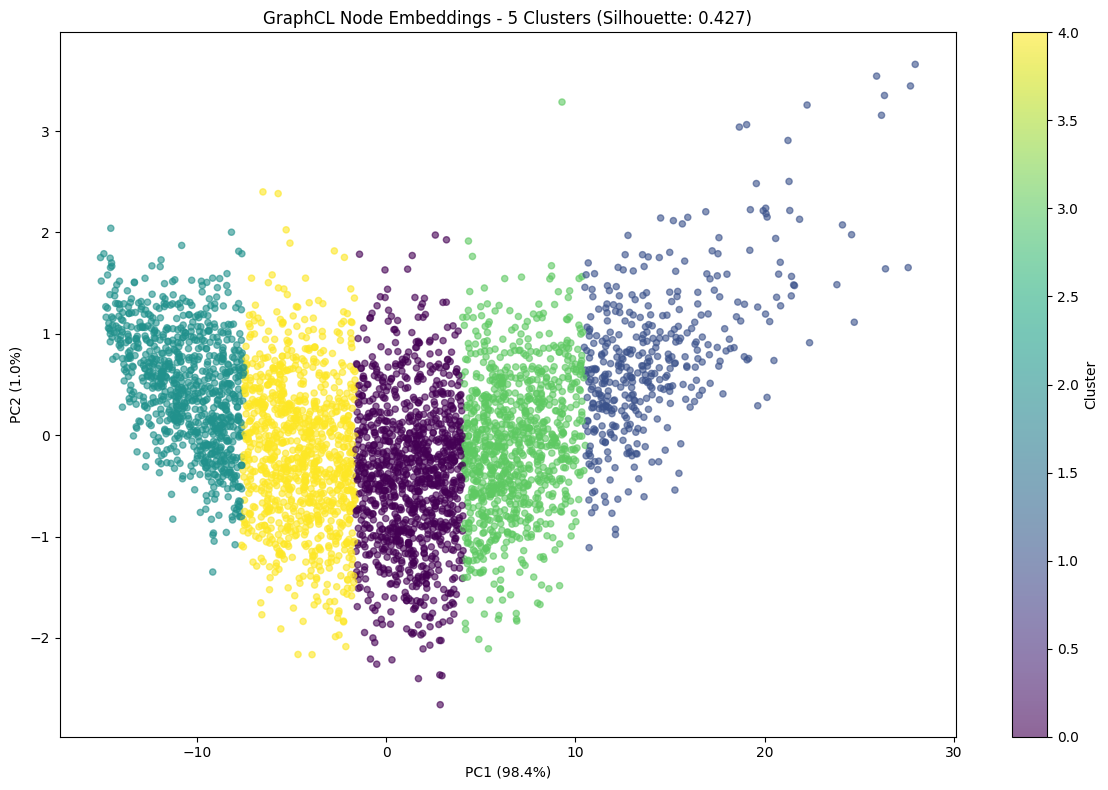


Visualization saved to: graphcl_clusters.png
PCA variance explained: 99.4%

Cluster Analysis:

Cluster 0 (1097 nodes):
  Avg event_count: 24.34
  Avg unique_players: 6.24
  Most common event type:
    DUEL: 113 (10.3%)
    PASS: 973 (88.7%)
    SHOT: 10 (0.9%)
    None: 1 (0.1%)
  Role distribution: [0.04806084 0.3019418  0.42463857 0.22444722]

Cluster 1 (406 nodes):
  Avg event_count: 59.83
  Avg unique_players: 8.47
  Most common event type:
    DUEL: 1 (0.2%)
    PASS: 405 (99.8%)
  Role distribution: [0.00870101 0.2832988  0.5057442  0.20225617]

Cluster 2 (862 nodes):
  Avg event_count: 3.66
  Avg unique_players: 2.27
  Most common event type:
    DUEL: 283 (32.8%)
    PASS: 501 (58.1%)
    SHOT: 42 (4.9%)
    None: 36 (4.2%)
  Role distribution: [0.11288809 0.37087327 0.27403033 0.19580425]

Cluster 3 (946 nodes):
  Avg event_count: 38.79
  Avg unique_players: 7.58
  Most common event type:
    DUEL: 16 (1.7%)
    PASS: 927 (98.0%)
    SHOT: 3 (0.3%)
  Role distribution: [0.029

In [22]:
# Dimensionality reduction for visualization
print("Visualizing clusters...")
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(all_embeddings)

# Plot clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                     c=cluster_labels, cmap='viridis', 
                     alpha=0.6, s=20)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title(f'GraphCL Node Embeddings - {k} Clusters (Silhouette: 0.427)')
plt.tight_layout()
plt.savefig('graphcl_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved to: graphcl_clusters.png")
print(f"PCA variance explained: {pca.explained_variance_ratio_.sum()*100:.1f}%")

# Analyze cluster characteristics
print("\n" + "="*60)
print("Cluster Analysis:")
print("="*60)

# Get back node features for analysis
all_node_features = []
for data in train_data + val_data + test_data:
    all_node_features.append(data.x.cpu().numpy())
all_node_features = np.vstack(all_node_features)

for cluster_id in range(k):
    mask = cluster_labels == cluster_id
    cluster_features = all_node_features[mask]
    
    print(f"\nCluster {cluster_id} ({mask.sum()} nodes):")
    print(f"  Avg event_count: {cluster_features[:, 0].mean():.2f}")
    print(f"  Avg unique_players: {cluster_features[:, 1+len(event_to_idx)].mean():.2f}")
    print(f"  Most common event type:")
    
    # Event type distribution (one-hot indices 1-5)
    event_counts = cluster_features[:, 1:1+len(event_to_idx)].sum(axis=0)
    event_types = list(event_to_idx.keys())
    for i, event_type in enumerate(event_types):
        if event_counts[i] > 0:
            print(f"    {event_type}: {event_counts[i]:.0f} ({event_counts[i]/mask.sum()*100:.1f}%)")
    
    # Role distribution
    role_dist = cluster_features[:, -4:].mean(axis=0)
    print(f"  Role distribution: {role_dist}")

print("\n" + "="*60)

In [23]:
# Quick comparison: How does this compare to your node2vec clustering?
print("GraphCL Results Summary:")
print("="*60)

# Distribution across splits
train_clusters = cluster_labels[:len(train_embeddings)]
val_clusters = cluster_labels[len(train_embeddings):len(train_embeddings)+len(val_embeddings)]
test_clusters = cluster_labels[-len(test_embeddings):]

print("\nCluster distribution by split:")
for split_name, split_clusters in [('Train', train_clusters), ('Val', val_clusters), ('Test', test_clusters)]:
    print(f"\n{split_name}:")
    unique, counts = np.unique(split_clusters, return_counts=True)
    for c, cnt in zip(unique, counts):
        print(f"  Cluster {c}: {cnt} ({cnt/len(split_clusters)*100:.1f}%)")

GraphCL Results Summary:

Cluster distribution by split:

Train:
  Cluster 0: 766 (25.5%)
  Cluster 1: 294 (9.8%)
  Cluster 2: 587 (19.5%)
  Cluster 3: 685 (22.8%)
  Cluster 4: 671 (22.3%)

Val:
  Cluster 0: 171 (26.5%)
  Cluster 1: 42 (6.5%)
  Cluster 2: 135 (20.9%)
  Cluster 3: 138 (21.4%)
  Cluster 4: 159 (24.7%)

Test:
  Cluster 0: 160 (24.4%)
  Cluster 1: 70 (10.7%)
  Cluster 2: 140 (21.4%)
  Cluster 3: 123 (18.8%)
  Cluster 4: 162 (24.7%)


In [24]:
print("="*70)
print("OVERFITTING ANALYSIS")
print("="*70)

# Compare train vs validation clustering quality
from sklearn.metrics import silhouette_score

train_sil = silhouette_score(train_embeddings, cluster_labels[:len(train_embeddings)])
val_sil = silhouette_score(val_embeddings, cluster_labels[len(train_embeddings):len(train_embeddings)+len(val_embeddings)])
test_sil = silhouette_score(test_embeddings, cluster_labels[-len(test_embeddings):])

print(f"\nSilhouette Scores by Split:")
print(f"   Train: {train_sil:.3f}")
print(f"   Val:   {val_sil:.3f}")
print(f"   Test:  {test_sil:.3f}")
print(f"   Gap:   {abs(train_sil - val_sil):.3f}")

if abs(train_sil - val_sil) > 0.1:
    print("\n Large train-val gap suggests overfitting!")
else:
    print("\n Generalization looks good")

OVERFITTING ANALYSIS

Silhouette Scores by Split:
   Train: 0.474
   Val:   0.494
   Test:  0.473
   Gap:   0.021

 Generalization looks good


## Visualise average graph clustering

In [25]:
# Import ZoneTransformer from your graph.py
from graph import ZoneTransformer

zt = ZoneTransformer()

# Create zone to cluster mapping
zone_to_cluster_votes = {}  # zone_id -> list of cluster assignments

node_idx = 0
for data in train_data + val_data + test_data:
    # Get the actual zone IDs from this graph (move to CPU first)
    present_zones = sorted(list(set(data.edge_index[0].cpu().numpy()) | set(data.edge_index[1].cpu().numpy())))
    
    for zone_id in present_zones:
        if zone_id not in zone_to_cluster_votes:
            zone_to_cluster_votes[zone_id] = []
        zone_to_cluster_votes[zone_id].append(cluster_labels[node_idx])
        node_idx += 1

# Aggregate: most common cluster per zone
zone_to_cluster = {}
for zone_id, votes in zone_to_cluster_votes.items():
    # Most common cluster for this zone
    zone_to_cluster[zone_id] = np.bincount(votes).argmax()

print(f"Mapped {len(zone_to_cluster)} zones to clusters")
print("\nZone-to-Cluster mapping:")
for zone_id in sorted(zone_to_cluster.keys()):
    zone_name = zt.get_zone_name(zone_id)
    cluster = zone_to_cluster[zone_id]
    print(f"  Zone {zone_id:2d} ({zone_name:30s}) -> Cluster {cluster}")

Mapped 41 zones to clusters

Zone-to-Cluster mapping:
  Zone  0 (LEFT_WING_DEF_BOX             ) -> Cluster 2
  Zone  1 (LEFT_HALF_DEF_BOX             ) -> Cluster 2
  Zone  2 (CENTER_DEF_BOX                ) -> Cluster 2
  Zone  3 (RIGHT_HALF_DEF_BOX            ) -> Cluster 2
  Zone  4 (RIGHT_WING_DEF_BOX            ) -> Cluster 2
  Zone  5 (LEFT_WING_DEF_PENALTY         ) -> Cluster 4
  Zone  6 (LEFT_HALF_DEF_PENALTY         ) -> Cluster 4
  Zone  7 (CENTER_DEF_PENALTY            ) -> Cluster 4
  Zone  8 (RIGHT_HALF_DEF_PENALTY        ) -> Cluster 0
  Zone  9 (RIGHT_WING_DEF_PENALTY        ) -> Cluster 3
  Zone 10 (LEFT_WING_DEF_THIRD_DEEP      ) -> Cluster 3
  Zone 11 (LEFT_HALF_DEF_THIRD_DEEP      ) -> Cluster 0
  Zone 12 (CENTER_DEF_THIRD_DEEP         ) -> Cluster 0
  Zone 13 (RIGHT_HALF_DEF_THIRD_DEEP     ) -> Cluster 3
  Zone 14 (RIGHT_WING_DEF_THIRD_DEEP     ) -> Cluster 3
  Zone 15 (LEFT_WING_DEF_THIRD           ) -> Cluster 3
  Zone 16 (LEFT_HALF_DEF_THIRD           ) -> Clus

In [26]:
# Deep cluster analysis - what makes each cluster unique?
print("="*70)
print(f"TACTICAL CLUSTER INTERPRETATION (k={k})")
print("="*70)

# Get all node features again
all_node_features = []
for data in train_data + val_data + test_data:
    all_node_features.append(data.x.cpu().numpy())
all_node_features = np.vstack(all_node_features)

# Analyze each cluster
for cluster_id in range(k):
    mask = cluster_labels == cluster_id
    cluster_features = all_node_features[mask]
    cluster_zones = [z for z, c in zone_to_cluster.items() if c == cluster_id and z != zt.outside_zone_id]
    
    print(f"\n{'='*70}")
    print(f"CLUSTER {cluster_id} ({mask.sum()} node instances, {len(cluster_zones)} zones)")
    print(f"{'='*70}")
    
    # Zones in this cluster
    print(f"\nZones: {sorted(cluster_zones)}")
    zone_names = [zt.get_zone_name(z) for z in sorted(cluster_zones)[:k]]
    print(f"   Examples: {', '.join(zone_names)}")
    
    # Event characteristics
    print(f"\nAverage Activity:")
    print(f"   Event count: {cluster_features[:, 0].mean():.1f} ± {cluster_features[:, 0].std():.1f}")
    print(f"   Unique players: {cluster_features[:, 1+len(event_to_idx)].mean():.1f}")
    
    # Event type distribution (features 1-5)
    print(f"\nEvent Type Distribution:")
    event_types = list(event_to_idx.keys())
    event_totals = cluster_features[:, 1:1+len(event_to_idx)].sum(axis=0)
    event_pcts = 100 * event_totals / event_totals.sum()
    
    for i, (event_type, pct) in enumerate(zip(event_types, event_pcts)):
        if pct > 5:  # Only show significant event types
            print(f"   {event_type:12s}: {pct:5.1f}%")
    
    # Player roles (last 4 features: GK, DEF, MID, FWD)
    print(f"\nDominant Player Roles:")
    role_names = ['Goalkeeper', 'Defender', 'Midfielder', 'Forward']
    role_pcts = 100 * cluster_features[:, -4:].mean(axis=0)
    for role, pct in zip(role_names, role_pcts):
        print(f"   {role:12s}: {pct:5.1f}%")

TACTICAL CLUSTER INTERPRETATION (k=5)

CLUSTER 0 (1097 node instances, 9 zones)

Zones: [np.int64(8), np.int64(11), np.int64(12), np.int64(22), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(38)]
   Examples: RIGHT_HALF_DEF_PENALTY, LEFT_HALF_DEF_THIRD_DEEP, CENTER_DEF_THIRD_DEEP, CENTER_MID_THIRD_DEF, RIGHT_WING_MID_THIRD_DEF

Average Activity:
   Event count: 24.3 ± 9.9
   Unique players: 6.2

Event Type Distribution:
   DUEL        :  10.3%
   PASS        :  88.7%

Dominant Player Roles:
   Goalkeeper  :   4.8%
   Defender    :  30.2%
   Midfielder  :  42.5%
   Forward     :  22.4%

CLUSTER 1 (406 node instances, 0 zones)

Zones: []
   Examples: 

Average Activity:
   Event count: 59.8 ± 19.7
   Unique players: 8.5

Event Type Distribution:
   PASS        :  99.8%

Dominant Player Roles:
   Goalkeeper  :   0.9%
   Defender    :  28.3%
   Midfielder  :  50.6%
   Forward     :  20.2%

CLUSTER 2 (862 node instances, 10 zones)

Zones: [np.int64(0), np.int64(1), np.int6

Cluster 4 represents low-activity box zones (3.9 events, 33% duels, 11% goalkeepers) at both penalty areas where defenders dominate high-stakes situations. Cluster 2 captures structured build-up zones in the defensive third with heavy passing activity (39.3 events, 98% passes, 46% midfielders). Cluster 3 forms the largest group of transition zones from deep defense to mid-attack with medium activity (25.7 events). Cluster 0 identifies wing areas (both defensive and attacking) with mixed duels (24%) and balanced player roles. !!! Cluster 1 represents hotspots without fixed spatial location—these are match-specific high-intensity hubs (59.9 events, 99.5% passes, 51% midfielders) that vary based on tactical tempo => GraphCL learned tactical similarity rather than spatial proximity.

c:\Portable\ProgramsPortable\Anaconda\envs\graphml\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\vladi\AppData\Local\Temp\ipykernel_20168\3132388508.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10')


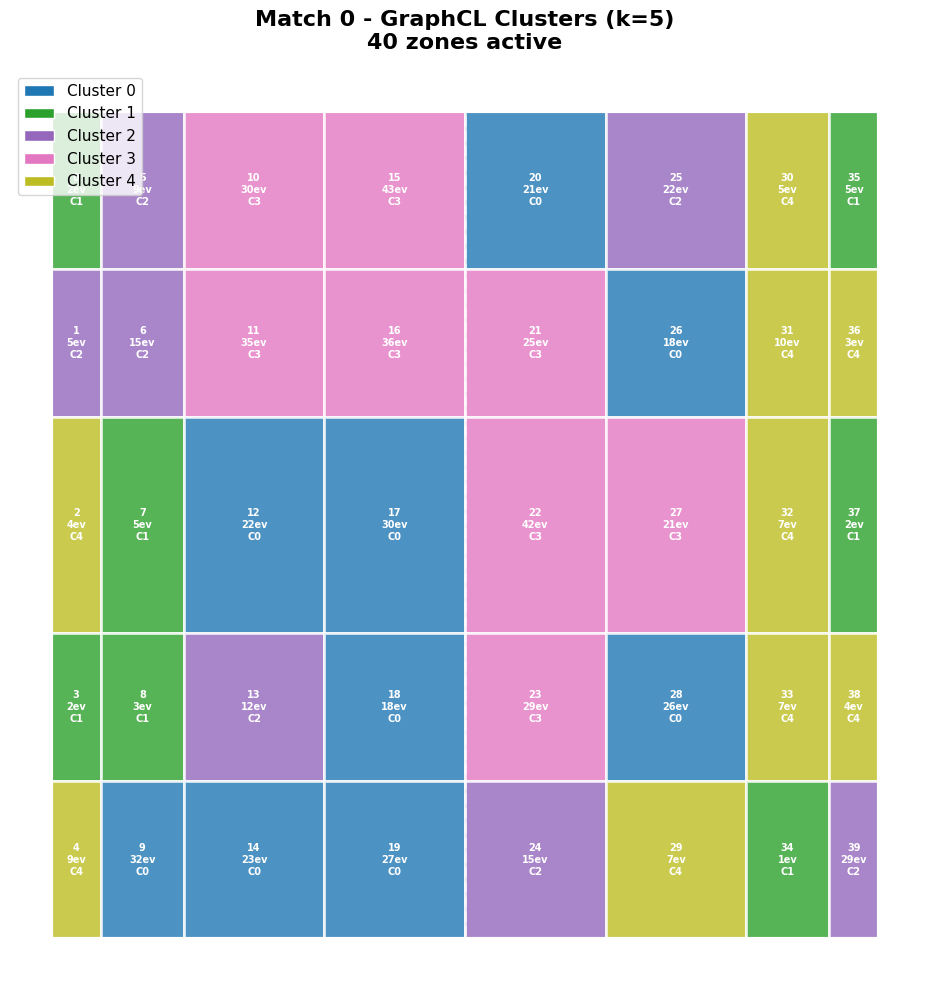


 Match 0 Summary:
  Active zones: 40
  Cluster distribution: [9 7 7 8 9]



c:\Portable\ProgramsPortable\Anaconda\envs\graphml\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\vladi\AppData\Local\Temp\ipykernel_20168\3132388508.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10')


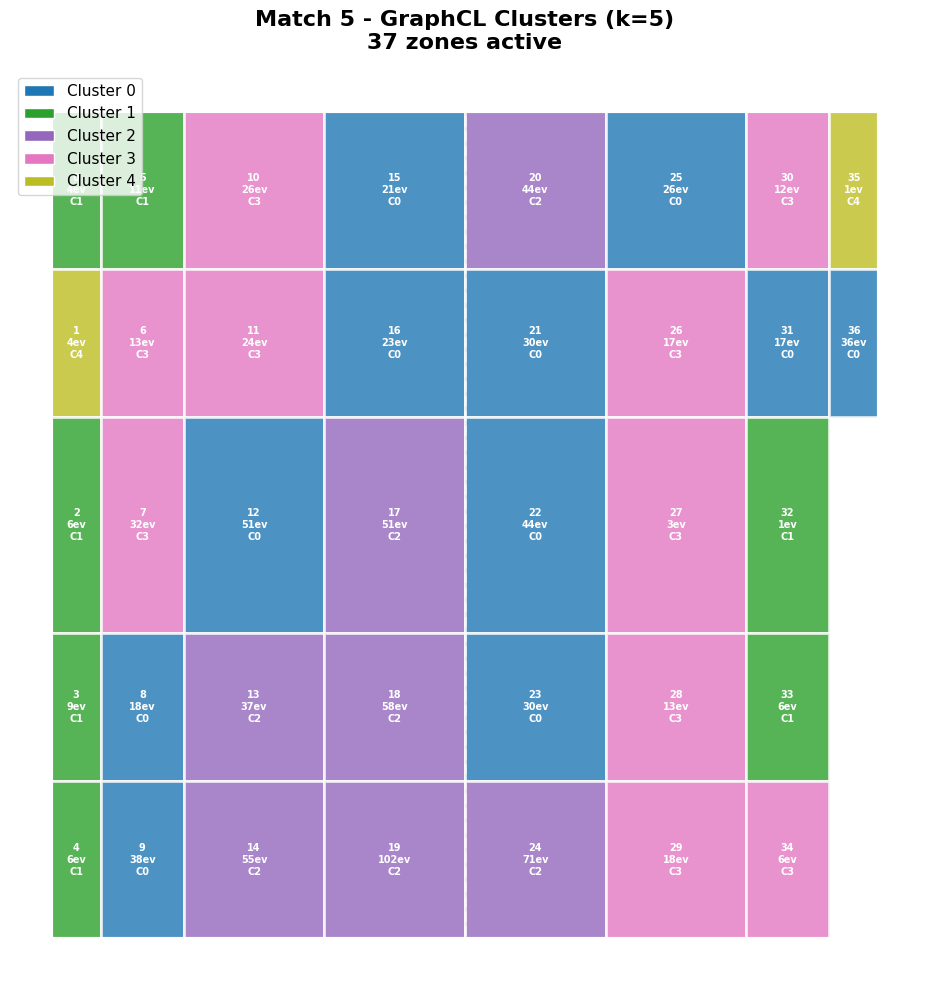


 Match 5 Summary:
  Active zones: 37
  Cluster distribution: [11  7  7 10  2]



c:\Portable\ProgramsPortable\Anaconda\envs\graphml\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\vladi\AppData\Local\Temp\ipykernel_20168\3132388508.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10')


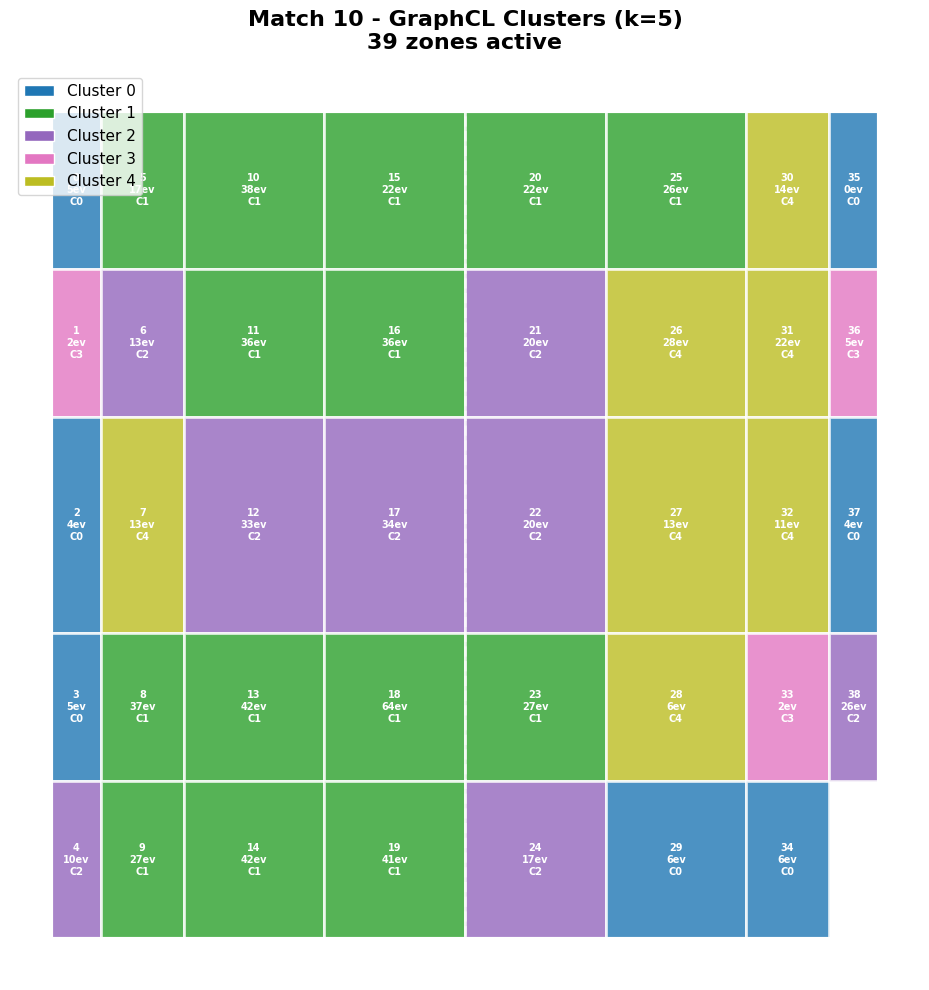


 Match 10 Summary:
  Active zones: 39
  Cluster distribution: [ 7 14  8  3  7]


In [27]:
def visualize_single_match_clusters(data, match_idx, encoder, zt, k=5):
    """
    Visualize clusters for ONE match on the pitch
    
    Args:
        data: PyG Data object for the match
        match_idx: Match number (for title)
        encoder: Trained GraphCL encoder
        zt: ZoneTransformer
        k: Number of clusters
    """
    
    # 1. Get embeddings for this match
    encoder.eval()
    with torch.no_grad():
        features, adj_sparse = preprocess_graph_for_dgi_undirected(data)
        adj_norm = normalize_adj(adj_sparse + sp.eye(adj_sparse.shape[0]))
        sp_adj = sparse_mx_to_torch_sparse_tensor(adj_norm).cuda()
        features = features.cuda()
        embeds, _ = encoder.embed(features, sp_adj, sparse, None)
        match_embeddings = embeds[0].cpu().numpy()
    
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    match_cluster_labels = kmeans.fit_predict(match_embeddings)
    
    # 3. Get zone IDs present in this match
    present_zones = sorted(list(set(data.edge_index[0].cpu().numpy()) | 
                                set(data.edge_index[1].cpu().numpy())))
    
    # 4. Map zones to clusters for THIS match
    zone_to_cluster_match = {}
    for local_idx, zone_id in enumerate(present_zones):
        zone_to_cluster_match[zone_id] = match_cluster_labels[local_idx]
    
    # 5. Plot
    fig, ax = plt.subplots(figsize=(16, 10))
    
    # Colors for clusters
    cmap = cm.get_cmap('tab10')
    colors = [cmap(i/k) for i in range(k)]
    
    # Draw each zone
    for zone_id, cluster in zone_to_cluster_match.items():
        if zone_id >= zt.n_zones:  # Skip OUTSIDE
            continue
            
        x_min, x_max, y_min, y_max = zt.get_zone_bounds(zone_id)
        
        rect = patches.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            linewidth=2, edgecolor='white',
            facecolor=colors[cluster], alpha=0.8
        )
        ax.add_patch(rect)
        
        # Show zone ID and event count
        x_center, y_center = zt.get_zone_center(zone_id)
        local_idx = present_zones.index(zone_id)
        event_count = int(data.x[local_idx, 0].item())
        
        ax.text(x_center, y_center, f'{zone_id}\n{event_count}ev\nC{cluster}', 
               ha='center', va='center', fontsize=7, 
               color='white', fontweight='bold')
    
    # Pitch markings
    ax.axvline(x=50, color='white', linewidth=2, linestyle='--', alpha=0.5)
    ax.plot([0, 100, 100, 0, 0], [0, 0, 100, 100, 0], color='white', linewidth=3)
    
    ax.set_xlim(-5, 105)
    ax.set_ylim(-5, 105)
    ax.set_aspect('equal')
    ax.set_facecolor('#1e7d32')
    ax.axis('off')
    
    # Legend
    legend_elements = [patches.Patch(facecolor=colors[i], edgecolor='white', 
                                     label=f'Cluster {i}')
                      for i in range(k)]
    ax.legend(handles=legend_elements, loc='upper left', fontsize=11)
    
    plt.title(f'Match {match_idx} - GraphCL Clusters (k={k})\n{len(present_zones)} zones active', 
             fontsize=16, fontweight='bold', pad=15)
    plt.tight_layout()
    plt.savefig(f'match_{match_idx}_k{k}.png', dpi=200, bbox_inches='tight', facecolor='#1e7d32')
    plt.show()
    
    # Print summary
    print(f"\n Match {match_idx} Summary:")
    print(f"  Active zones: {len(present_zones)}")
    print(f"  Cluster distribution: {np.bincount(match_cluster_labels)}")
    
    return zone_to_cluster_match

# Example: Visualize matches 0, 5, 10
for match_idx in [0, 5, 10]:
    print(f"\n{'='*60}")
    zone_map = visualize_single_match_clusters(train_data[match_idx], match_idx, encoder, zt, k=5)

##### Match 0: 
Balanced tactical approach, clustering dist relatively even spread across all patterns

##### Match 5: 
Defensive/Transition dominated; Suggests defensive/counter-attacking style

##### Match 10: 
High intensity match; Cluster 1 (green) = 12 zones! (59.9 avg events for cluster 1); This was a high tempo match with intense activity